# Problem Statement:-

### 1. Predict the bus ridetrship at a given stop for a route at a given time.

### 2. Predict the daily bus ridership for a given stop for a route.

#### Disclaimer: Whole POC is based on open data

In [353]:
# Include all the required liberaries
import pandas as pd
import numpy as np
import psycopg2 as pg
import psycopg2 as pg
import datetime
from collections import defaultdict, OrderedDict
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import geocoder

from sklearn.model_selection import KFold, cross_val_score, TimeSeriesSplit
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

In [235]:
#Declare global variables for notebook
seed = 1
num_folds = 10
test_size = 0.3
scoring = 'neg_mean_squared_error'
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
tss = TimeSeriesSplit(max_train_size=None, n_splits=num_folds)
route_name = 'X25'

In [236]:
#Using psycopg2 python liberary
import getpass
password = getpass.getpass()
hostname ="127.0.0.1"               ## INSERT YOUR DB Host ADDRESS for Greenplum
port     = "5432"                 ## INSERT YOUR DB port for Greenplum connection
db_name  ="SDP_DEV"                ## INSERT YOUR DB Name for Greenplum connection
user     ="amit.jha"              ## INSERT YOUR DB Name for Greenplum connection
conn     = pg.connect(host=hostname, port=port, database=db_name,  user=user, password=password)

········


## Load the data and do feature engineering

In [305]:
# Get Bus Ridership data
ridership_df       = pd.read_sql("select * from rta.agg_bus_ridership_day where route_name in ('X25') order by txn_date;", conn)
ridership_df.head(2)

,txn_type,txn_date,location,route_name,zone,ridership_count
0,Check out,2017-01-01,Blue Tower 1,X25,Zone 4,1.0
1,Check in,2017-01-01,Silicon Oasis 5 2,X25,Zone 4,1.0


In [306]:
ridership_df.rename(columns={"location": "stop_name"}, inplace=True)
ridership_df['txn_date'] = pd.to_datetime(ridership_df['txn_date'])
ridership_df['dayofweek'] = ridership_df['txn_date'].dt.dayofweek
ridership_df['year'] = ridership_df['txn_date'].dt.year
ridership_df['month'] = ridership_df['txn_date'].dt.month
ridership_df['day'] = ridership_df['txn_date'].dt.day
ridership_df['weekday'] = ridership_df['dayofweek'].map(lambda s: 1 if s in {6,0,1,2,3} else 0)

In [307]:
# Load the Bus Stations data
# stations_df = pd.read_sql("select * from bus_stations;", conn)
bus_stations = "Bus_Stations.csv"
stations_df = pd.read_csv(bus_stations)
stations_df = stations_df[stations_df['route_name'] == route_name]
# stations_df.drop(columns={'upload_timestamp', 'upload_ingestion_id'}, inplace=True)
stations_df.drop_duplicates(subset=['stop_name', 'route_name'], keep='first', inplace=True)
stations_df.head(2)

,stop_name,route_name,stop_location_longitiude,stop_location_latitiude
1285,Al Karama Bus Station 2,X25,55.302963,25.237703
2963,Axis 1 Residence,X25,NaN,NaN


In [240]:
# locator = Nominatim(user_agent="myGeocoder")
# location = locator.geocode("Capital Hotel, Dubai")
# print("Latitude: {}, Longitude= {}".format(location.latitude, location.longitude))

In [241]:
# Finding longitude & latitude with geopy
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# stations_df['bus_stop_address'] = stations_df['stop_name'].apply(lambda x: x + ", Dubai, UAE")
# stations_df['location'] = stations_df['bus_stop_address'].apply(geocode)
# stations_df['point'] = stations_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# stations_df[['latitude1', 'longitude1', 'altitude1']] = pd.DataFrame(stations_df['point'].tolist(), index=stations_df.index)

In [242]:
stations_df.set_value(2963, 'stop_location_latitiude', 25.1257)
stations_df.set_value(2963, 'stop_location_longitiude', 55.4038)
stations_df.set_value(2966, 'stop_location_latitiude', 25.1286)
stations_df.set_value(2966, 'stop_location_longitiude', 55.4025)
stations_df.set_value(5258, 'stop_location_latitiude', 25.1233)
stations_df.set_value(5258, 'stop_location_longitiude', 55.4194)
stations_df.set_value(5260, 'stop_location_latitiude', 25.1233)
stations_df.set_value(5260, 'stop_location_longitiude', 55.4194)
stations_df.set_value(14218, 'stop_location_latitiude', 25.1318)
stations_df.set_value(14218, 'stop_location_longitiude', 55.3871)

stations_df[stations_df['stop_location_latitiude'].isnull()]

,stop_name,route_name,stop_location_longitiude,stop_location_latitiude
3138,Bin Ghatti Apartments,X25,NaN,NaN


In [308]:
# Combine Ridership and Bus Stations data
ridership_stations_df = pd.merge(ridership_df, stations_df, how='left', on=['route_name' ,'stop_name'])

In [309]:
# Load the weather data for last three year(2017, 2018 & 2019)
weather_df = pd.read_csv('weather_daily.csv')
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df['year'] = weather_df['Date'].dt.year
weather_df['month'] = weather_df['Date'].dt.month
weather_df['day'] = weather_df['Date'].dt.day

weather_df.drop(columns={'Date','DayofMonth'}, inplace=True)

In [310]:
# Combine the ridership_stations and weather data
ridership_stations_weather_df = pd.merge(ridership_stations_df, weather_df, how='inner', on=['year' ,'month', 'day'])
ridership_stations_weather_df.head(2)

,txn_type,txn_date,stop_name,route_name,zone,ridership_count,dayofweek,year,month,day,...,HumidityMax,HumidityAvg,HumidityMin,WindSpeedMax,WindSpeedAvg,WindSpeedMin,PressureMax,PressureAvg,PressureMin,Precipitation
0,Check out,2017-01-01,Blue Tower 1,X25,Zone 4,1.0,6,2017,1,1,...,88,75.3,58,10,6.0,3,30.0,30.0,30.0,0
1,Check in,2017-01-01,Silicon Oasis 5 2,X25,Zone 4,1.0,6,2017,1,1,...,88,75.3,58,10,6.0,3,30.0,30.0,30.0,0


In [311]:
# Load the holiday data for last two years(2017 & 2018)
holiday_df = pd.read_csv('HolidaySheet.csv')
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])
holiday_df['year'] = holiday_df['Date'].dt.year
holiday_df['month'] = holiday_df['Date'].dt.month
holiday_df['day'] = holiday_df['Date'].dt.day

holiday_df.drop(columns='Date', inplace=True)

In [312]:
# Combine ridership_stations_weather data created earlier with Hoilday data
result_df = ridership_stations_weather_df.combine_first(holiday_df)
result_df.head(2)

,DewAvg,DewMax,DewMin,Duration,HumidityAvg,HumidityMax,HumidityMin,Occasion,Precipitation,PressureAvg,...,ridership_count,route_name,stop_location_latitiude,stop_location_longitiude,stop_name,txn_date,txn_type,weekday,year,zone
0,63.5,66,61,1.0,75.3,88,58,New Year's Day,0,30.0,...,1.0,X25,25.112059,55.375957,Blue Tower 1,2017-01-01,Check out,1,2017,Zone 4
1,63.5,66,61,1.0,75.3,88,58,Isra Wal Mi'raj,0,30.0,...,1.0,X25,25.109447,55.384146,Silicon Oasis 5 2,2017-01-01,Check in,1,2017,Zone 4


In [313]:
result_df.rename(columns={'Duration': 'holidayDuration'}, inplace=True)
result_df['holidayDuration'] = result_df['holidayDuration'].fillna(0)
result_df['holiday'] = result_df['holidayDuration'].apply(lambda x: 1 if x > 0 else 0)
result_df['Occasion'] = result_df['Occasion'].fillna('noHoliday')
result_df.drop(columns='txn_date', inplace=True)
result_df['stop_location_longitiude'] = result_df['stop_location_longitiude'].fillna(0)
result_df['stop_location_latitiude'] = result_df['stop_location_latitiude'].fillna(0)
result_df.drop(columns='route_name', inplace=True)
result_df.head(1)

,DewAvg,DewMax,DewMin,holidayDuration,HumidityAvg,HumidityMax,HumidityMin,Occasion,Precipitation,PressureAvg,...,month,ridership_count,stop_location_latitiude,stop_location_longitiude,stop_name,txn_type,weekday,year,zone,holiday
0,63.5,66,61,1.0,75.3,88,58,New Year's Day,0,30.0,...,1,1.0,25.112059,55.375957,Blue Tower 1,Check out,1,2017,Zone 4,1


### Do some EDA on the data to get some insight

In [314]:
sns.set(style="darkgrid")

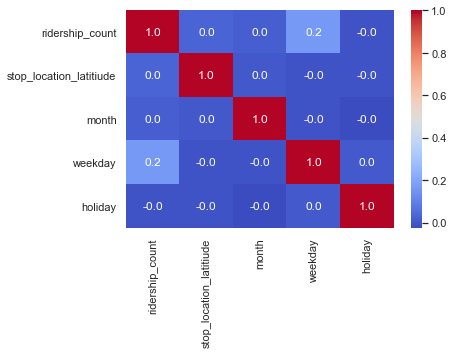

In [250]:
plot = sns.heatmap(result_df[['ridership_count', 'stop_location_latitiude', 'month', 'weekday', 'holiday', 'stop_name', 'zone']].corr(),
                   annot=True, fmt = ".1f", cmap='coolwarm');

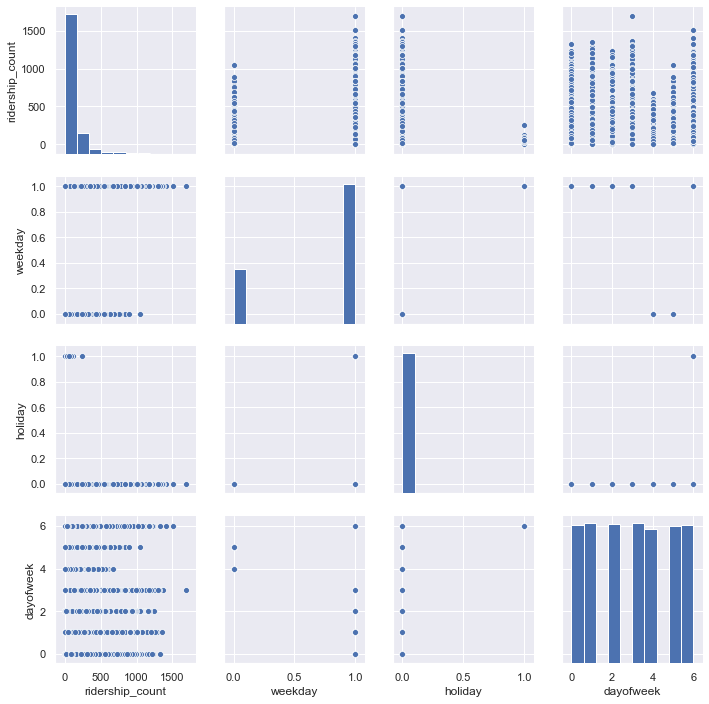

In [251]:
sns.pairplot(result_df, vars = ["ridership_count", 'weekday', 'holiday', 'dayofweek']);

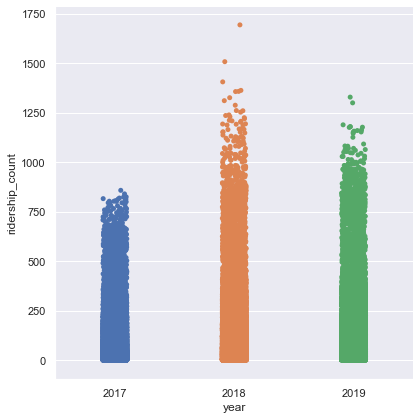

In [252]:
#Age / Survival correlation
sns.catplot(x='year', y='ridership_count', kind="strip", data=result_df, height=6);

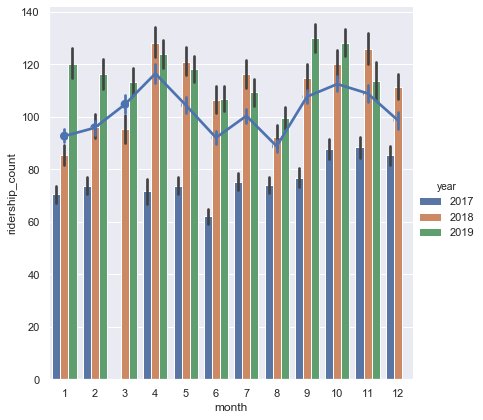

In [253]:
#Age / Survival correlation
sns.catplot(x='month', y='ridership_count', kind="bar", hue='year',data=result_df, height=6);
sns.pointplot(x='month', y='ridership_count', kind="point", data=result_df, height=6);

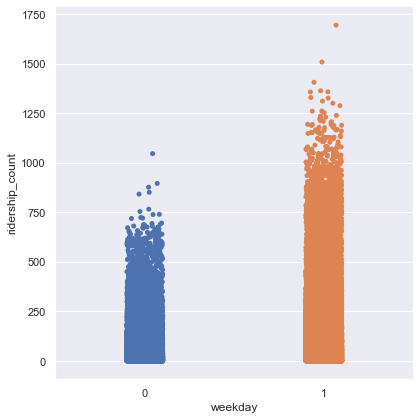

In [254]:
#Age / Survival correlation
sns.catplot(x='weekday', y='ridership_count', kind="strip", data=result_df, height=6);

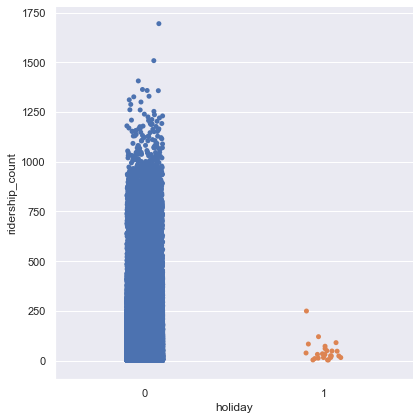

In [255]:
#Age / Survival correlation
sns.catplot(x='holiday', y='ridership_count', kind="strip", data=result_df, height=6);

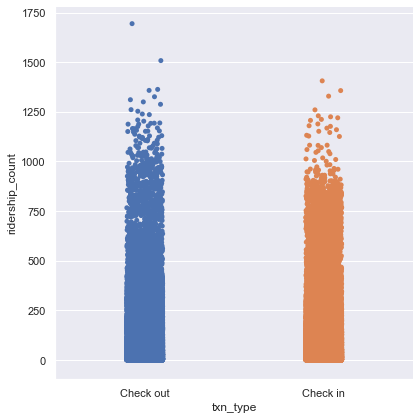

In [256]:
#Age / Survival correlation
sns.catplot(x='txn_type', y='ridership_count', kind="strip", data=result_df, height=6);

## Feature engineering on final data

In [258]:
cat_num_features = ['holidayDuration','Occasion', 'day','dayofweek', 'month', 'stop_name', 'txn_type', 'weekday',
                    'year','zone', 'holiday']

In [315]:
def feature_engineering(df):
            
    print(df.shape)
    #Work on categorical data convert them to numerical values
    features_to_use = df.columns
    categorical = ['txn_type','stop_name', 'zone', 'Occasion']
    lencat=len(categorical)
    for c in categorical:
      if df[c].dtype == 'object':
        df[c] = df[c].astype('category')
        df[c] = df[c].cat.codes
    for c in features_to_use:
        if c not in categorical:
            df[c] = df[c].astype('float64')
    return df        

def one_hot_encoding(df, features):
    for f in features:
        df = pd.DataFrame(data=df, columns=['f'])
    return df

### Choosing the specific year data for learning/testing

In [340]:
train = result_df.loc[result_df['year'] == 2017]

train_X = train.drop('ridership_count', axis=1)
train_y = train['ridership_count']
train_X.shape

(31235, 29)

In [341]:
# df = train_X.copy()
train_X = feature_engineering(train_X)
# data = one_hot_encoding(data, cat_num_features)
train_X = pd.get_dummies(data=train_X, columns=['holidayDuration','Occasion', 'day','dayofweek', 'month', 'stop_name', 'txn_type', 'weekday',
                    'year','zone', 'holiday'])
train_X.head(2)

(31235, 29)


,DewAvg,DewMax,DewMin,HumidityAvg,HumidityMax,HumidityMin,Precipitation,PressureAvg,PressureMax,PressureMin,...,weekday_0.0,weekday_1.0,year_2017.0,zone_0,zone_1,zone_2,zone_3,zone_4,holiday_0.0,holiday_1.0
0,63.5,66.0,61.0,75.3,88.0,58.0,0.0,30.0,30.0,30.0,...,0,1,1,0,0,0,1,0,0,1
1,63.5,66.0,61.0,75.3,88.0,58.0,0.0,30.0,30.0,30.0,...,0,1,1,0,0,0,1,0,0,1


### Split the data into train/test based on TimeSeriesSplit()

In [195]:
# # Split the data for training and test/validation using TimeSeriesSplit
# tscv = TimeSeriesSplit()
# for train_index, test_index in tscv.split(train_X):
#     train_data, vald_data = train_X.iloc[train_index], train_X.iloc[test_index]
#     train_labels, vald_labels = train_y.iloc[train_index], train_y.iloc[test_index]
    
# for train_index, test_index in tscv.split(vald_data):
#     train_vald_data, test_vald_data = vald_data.iloc[train_index], vald_data.iloc[test_index]
#     train_vald_labels, test_vald_labels = vald_labels.iloc[train_index], vald_labels.iloc[test_index]

### Scaling of the data: StandardScaler

In [342]:
scaler = preprocessing.StandardScaler()
train_X = scaler.fit_transform(train_X)

In [196]:
# Used with TimeSeriesSplit
# scaler = preprocessing.StandardScaler()
# train_data = scaler.fit_transform(train_data)

# train_vald_data = scaler.transform(train_vald_data)
# test_vald_data = scaler.transform(test_vald_data)

## Split the data into train/test

In [343]:
# Split the data for training and test/validation using TimeSeriesSplit
train_data, vald_data, train_labels, vald_labels = train_test_split(train_X, train_y, test_size=test_size, random_state=seed)

train_vald_data, test_vald_data, train_vald_labels, test_vald_labels = train_test_split(vald_data, vald_labels, test_size=test_size, random_state=seed)

In [321]:
# scaler = preprocessing.StandardScaler()
# train_data = scaler.fit_transform(train_data)

# train_vald_data = scaler.transform(train_vald_data)
# test_vald_data = scaler.transform(test_vald_data)

### Do some EDA on the data to get some insight

**Comparing Machine Algorithms**

In [266]:
#Prepare the models
models =[]
# models.append(('LR', LinearRegression()))
models.append(('RG', Ridge()))
models.append(('LS', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('XGB', xgb.XGBRegressor(objective="reg:squarederror")))
models.append(('LGB', lgb.LGBMRegressor()))
# models.append(('SVM', SVR()))
results = []
names = []

RG: -5420.900457: (318.589420)
LS: -6612.407350: (406.960831)
EN: -8788.773248: (615.005597)
KNN: -11735.976010: (751.534101)
CART: -967.611877: (97.443661)
XGB: -2510.710595: (115.670940)
LGB: -502.677556: (23.531518)


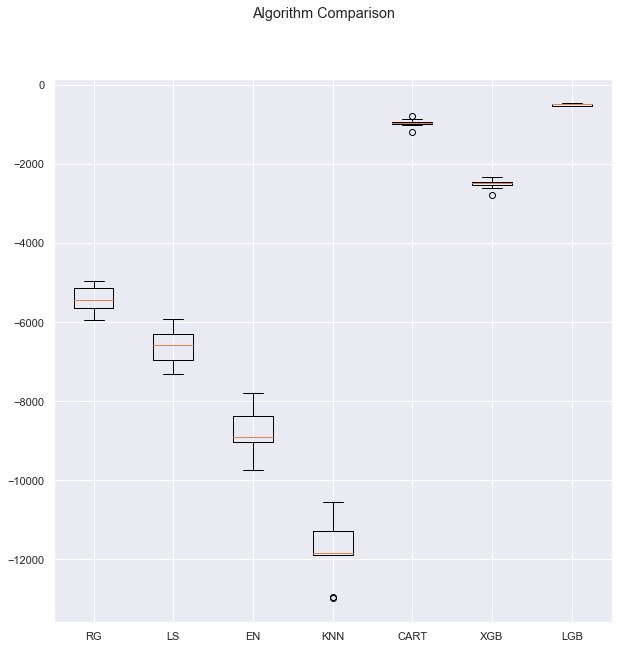

In [267]:
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed )
  cv_results = cross_val_score(model, train_data, train_labels, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f: (%f)" % (name, cv_results.mean(), cv_results.std() )
  print(msg)
  
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
# LR: -7569.622050: (1038.580639)
# RG: -7569.830348: (1038.906027)
# LS: -7600.289698: (1074.513775)
# EN: -7951.683308: (1139.804403)
# KNN: -7132.711578: (1007.018603)
# CART: -1714.933392: (1020.072988)
# LGB: -980.812200: (329.731635)


# Latest after feature scaling
# RG: -5408.131264: (332.492033)
# LS: -5454.829732: (341.586952)
# EN: -5854.590175: (457.226918)
# KNN: -4900.900050: (519.613268)
# CART: -975.540076: (72.569842)
# XGB: -2522.115962: (106.309839)
# LGB: -521.051262: (41.367971)

**Automated Workflow using Pipeline - Comparing Algorithm**

In [268]:
i=0
results = []
for name, model in models:
  estimators = []
  estimators.append(('standaridge', preprocessing.StandardScaler()))
  estimators.append(models[i])
  modelPipeline = Pipeline(estimators)
  cv_results = cross_val_score(modelPipeline, train_data, train_labels, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print("%s %f %f" % (name, cv_results.mean(), cv_results.std()))
  i += 1

RG -5421.482324 318.181213
LS -5465.593555 336.428199
EN -5876.060841 399.786746
KNN -4932.279735 335.057938
CART -996.515791 110.411849
XGB -2510.710595 115.670940
LGB -502.677556 23.531518


## Create XGB model

### XGB parameters tuning(Using RandomizedSearch)

In [200]:
# for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8],
   'gamma':[0,0.03,0.1,0.3],
   'min_child_weight':[1.5,6,10],
   'learning_rate':[0.1,0.07],
   'max_depth':[5,10],
   'n_estimators':[1000],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6,0.95]  
}

                    
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=1)

gsearch1 = RandomizedSearchCV(estimator = xgb_model, param_distributions = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(train_data,train_labels)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   56.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done  23 out of  30 | elapsed:  4.7min remaining:  1.4min
[Parallel(n_jobs=6)]: Done  27 out of  30 | elapsed:  6.4min remaining:   42.3s
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  6.6min finished


[02:46:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
best params
{'subsample': 0.95, 'reg_lambda': 0.45, 'reg_alpha': 1e-05, 'n_estimators': 1000, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.07, 'gamma': 0.1, 'colsample_bytree': 0.8}
best score
-650.1884262292104


In [300]:
def modelDef_cross_validation(train_data, train_labels, test_data, test_labels):

# Initial parameters:
#     param = {}
#     param['booster']='gbtree'
#     param['objective'] = 'reg:squarederror'
#     param['bst:eta'] = 0.04
#     param['seed']=  1
#     param['bst:max_depth'] = 6
#     param['bst:min_child_weight']= 1.
#     param['silent'] =  1  
#     param['nthread'] = 12 # put more if you have
#     param['bst:subsample'] = 0.7
#     param['eval_metric'] = 'rmse'
#     param['gamma'] = 1.0
#     param['colsample_bytree']= 1.0
#     param['num_parallel_tree']= 3   
#     param['colsample_bylevel']= 0.7                  
#     param['lambda']=5  

# Parameters set after running RandomizedSearchCV
    param = {}
    param['booster']='gbtree'
    param['objective'] = 'reg:squarederror'
    param['bst:eta'] = 0.07
    param['seed']=  1
    param['bst:max_depth'] = 5
    param['bst:min_child_weight']= 10.
    param['silent'] =  1  
    param['nthread'] = 12 # put more if you have
    param['bst:subsample'] = 0.95
    param['eval_metric'] = 'rmse'
    param['gamma'] = 0.1
    param['colsample_bytree']= 0.8
    param['num_parallel_tree']= 3   
    param['colsample_bylevel']= 0.7                  
    param['lambda']=5  
    param['reg_lambda']=0.01
    param['reg_alpha']=1e-05

#     {'subsample': 0.95, 'reg_lambda': 0.45, 'reg_alpha': 1e-05, 'n_estimators': 1000, 'min_child_weight': 10, 
#      'max_depth': 10, 'learning_rate': 0.07, 'gamma': 0.3, 'colsample_bytree': 0.6}
# -1162.2006688673953}

# {'subsample': 0.95, 'reg_lambda': 0.01, 'reg_alpha': 1e-05, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 5, 
#     'learning_rate': 0.07, 'gamma': 0.1, 'colsample_bytree': 0.8}
# best score
# -415.8296725435786

# With TimeSeriesSplit
# {'subsample': 0.95, 'reg_lambda': 0.45, 'reg_alpha': 1e-05, 'n_estimators': 1000, 'min_child_weight': 6, 'max_depth': 5, 
#  'learning_rate': 0.07, 'gamma': 0.1, 'colsample_bytree': 0.8}
# best score
# -650.1884262292104
    xg_train = xgb.DMatrix(data=train_data, label=train_labels)
    xg_test  = xgb.DMatrix(data=test_data, label=test_labels)
    cv_results = xgb.cv(dtrain=xg_train, params=param, nfold=5, num_boost_round=300,early_stopping_rounds=20,metrics="rmse", as_pandas=True,
                        seed=seed, verbose_eval=True)
    print(cv_results.mean(), cv_results.std())    
    
    watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
    #Training the model on training data to be used for predictions
    print(train_data.shape, train_labels.shape)
    print("trainging of the model started - sit tight and relax")
    xgb_clf = xgb.train(param, xg_train, num_boost_round=300, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)
    
    return param, xgb_clf
#     return param

In [301]:
def final_modelDef_training(param, train_data, train_labels):

    xg_train = xgb.DMatrix(data=train_data, label=train_labels)
    #Training the model on training data to be used for predictions
    print(train_data.shape, train_labels.shape)
    print("trainging of the model started - sit tight and relax")
    xgb_clf = xgb.train(param, xg_train, num_boost_round=130, verbose_eval=True)
    
    return xgb_clf

In [361]:
def model_test(param, model, vald_data, vald_labels):
    xgVald = xgb.DMatrix(vald_data)
    pred_y = model.predict(xgVald)    
    mean_square_error = mean_squared_error(vald_labels, pred_y)
    mean_abs_error = mean_absolute_error(test_vald_labels, pred_y)
    print("mean_square_error:", mean_square_error)
    print("mean_abs_error:", mean_abs_error)

    return pred_y, mean_square_error

In [333]:
#Define and train model 
param, xgb_clf = modelDef_cross_validation(train_data, train_labels, train_vald_data, train_vald_labels)

# param = modelDef_cross_validation(train_data, train_labels, train_vald_data, train_vald_labels)
# Stopping. Best iteration:
# [192]	train-rmse:11.4633	test-rmse:19.8807

[0]	train-rmse:95.6665+0.280352	test-rmse:95.782+1.40427
[1]	train-rmse:77.598+0.908429	test-rmse:77.8948+1.42089
[2]	train-rmse:65.771+0.763653	test-rmse:66.4065+0.461187
[3]	train-rmse:57.871+0.993075	test-rmse:58.6727+0.738263
[4]	train-rmse:53.0274+0.741824	test-rmse:54.1063+1.11304
[5]	train-rmse:49.404+1.34288	test-rmse:50.627+1.11112
[6]	train-rmse:46.6865+1.39268	test-rmse:47.9166+0.956368
[7]	train-rmse:44.9467+1.26967	test-rmse:46.3038+0.788055
[8]	train-rmse:43.5136+1.22696	test-rmse:44.9786+0.68826
[9]	train-rmse:42.415+1.44302	test-rmse:43.9864+1.00093
[10]	train-rmse:41.4897+1.46628	test-rmse:43.1093+0.876057
[11]	train-rmse:40.7807+1.47003	test-rmse:42.4474+0.886007
[12]	train-rmse:40.1039+1.41297	test-rmse:41.8149+0.828394
[13]	train-rmse:38.9732+1.35054	test-rmse:40.6626+0.897725
[14]	train-rmse:38.05+1.0084	test-rmse:39.7894+0.664979
[15]	train-rmse:37.3765+1.34434	test-rmse:39.179+0.862262
[16]	train-rmse:36.7604+1.49957	test-rmse:38.6159+1.03625
[17]	train-rmse:36.3

[138]	train-rmse:12.5749+0.182805	test-rmse:20.4655+0.736719
[139]	train-rmse:12.5188+0.159586	test-rmse:20.4522+0.74328
[140]	train-rmse:12.4755+0.152178	test-rmse:20.4446+0.735646
[141]	train-rmse:12.426+0.158424	test-rmse:20.424+0.728103
[142]	train-rmse:12.3684+0.173505	test-rmse:20.3995+0.730766
[143]	train-rmse:12.3292+0.18265	test-rmse:20.3928+0.733639
[144]	train-rmse:12.2698+0.180197	test-rmse:20.3733+0.736516
[145]	train-rmse:12.2388+0.183908	test-rmse:20.3657+0.740335
[146]	train-rmse:12.2068+0.191426	test-rmse:20.359+0.74694
[147]	train-rmse:12.1853+0.198062	test-rmse:20.3553+0.746781
[148]	train-rmse:12.1477+0.198014	test-rmse:20.3504+0.751549
[149]	train-rmse:12.0961+0.180125	test-rmse:20.3373+0.756773
[150]	train-rmse:12.0674+0.186584	test-rmse:20.3371+0.755269
[151]	train-rmse:12.0259+0.18173	test-rmse:20.3379+0.756737
[152]	train-rmse:11.9879+0.172495	test-rmse:20.3285+0.755606
[153]	train-rmse:11.9523+0.178196	test-rmse:20.3218+0.760102
[154]	train-rmse:11.923+0.18055

[84]	train-rmse:15.8397	test-rmse:21.3629
[85]	train-rmse:15.8082	test-rmse:21.341
[86]	train-rmse:15.7547	test-rmse:21.3147
[87]	train-rmse:15.7248	test-rmse:21.3147
[88]	train-rmse:15.6906	test-rmse:21.2994
[89]	train-rmse:15.6603	test-rmse:21.2945
[90]	train-rmse:15.6119	test-rmse:21.3038
[91]	train-rmse:15.5833	test-rmse:21.2899
[92]	train-rmse:15.5413	test-rmse:21.2776
[93]	train-rmse:15.4449	test-rmse:21.2097
[94]	train-rmse:15.4154	test-rmse:21.2019
[95]	train-rmse:15.3801	test-rmse:21.1934
[96]	train-rmse:15.3479	test-rmse:21.1694
[97]	train-rmse:15.2252	test-rmse:21.1076
[98]	train-rmse:15.1572	test-rmse:21.0778
[99]	train-rmse:15.0759	test-rmse:21.0366
[100]	train-rmse:14.9219	test-rmse:20.9277
[101]	train-rmse:14.8535	test-rmse:20.9018
[102]	train-rmse:14.7086	test-rmse:20.8248
[103]	train-rmse:14.6555	test-rmse:20.7988
[104]	train-rmse:14.5771	test-rmse:20.751
[105]	train-rmse:14.5434	test-rmse:20.7481
[106]	train-rmse:14.5221	test-rmse:20.7345
[107]	train-rmse:14.4978	test

In [362]:
pred_y, mean_square_error = model_test(param, xgb_clf, test_vald_data, test_vald_labels)

# After feature scaling on 2017 year data
# 373.39624275560595
# 368.93802376644584

mean_square_error: 345.1577716571792
mean_abs_error: 11.913544748778618


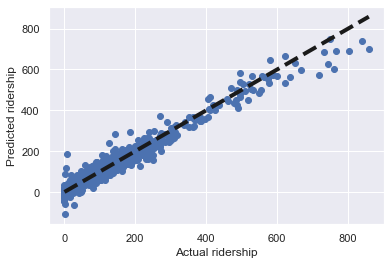

In [325]:
y = test_vald_labels
fig, ax = plt.subplots()
ax.scatter(y, pred_y)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual ridership')
ax.set_ylabel('Predicted ridership')
plt.show()

In [335]:
pd.set_option("display.max_rows", 100)
result = pd.DataFrame(test_vald_data)
result['actual_ridership'] = test_vald_labels.values
result['predicted_ridership'] = pred_y
result.tail(100)

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,actual_ridership,predicted_ridership
2712,-1.498644,-1.479080,-0.741860,-0.108471,-0.307744,0.707502,0.0,0.562447,0.750488,0.127862,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,3.0,0.006341
2713,0.662671,1.019258,0.519863,-0.958018,-0.594563,-0.927855,0.0,-1.280959,-1.640769,-0.044349,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,33.0,32.007717
2714,-2.337363,-2.624151,-2.093705,-0.763168,-0.953086,-0.694233,0.0,1.299810,1.547573,0.231188,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,176.0,189.074219
2715,-0.584655,-0.854495,0.159371,0.296817,-0.020925,0.629627,0.0,0.931128,1.149030,0.196746,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,30.0,7.795337
2716,0.006749,0.394674,0.069248,-0.521554,0.409303,-0.460611,0.0,-0.174916,-0.046598,0.093420,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,363.0,368.416504
2717,0.619660,0.082381,1.150724,0.250053,-0.164334,0.785376,0.0,-0.174916,-0.046598,0.058978,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,133.0,120.018753
2718,-1.025520,-0.854495,-0.922106,0.343581,0.337599,-0.304862,0.0,1.299810,1.149030,0.196746,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,490.0,409.846954
2719,0.254064,1.747940,0.159371,-1.246396,0.839532,-0.772107,0.0,-1.280959,-1.242226,-0.009906,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,63.0,56.535347
2720,-0.649172,-1.062690,-0.110998,1.185333,0.624418,1.174746,0.0,0.931128,0.750488,0.196746,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,113.0,122.512573
2721,-1.176059,-1.687275,-0.471490,-0.046119,-0.307744,0.396005,0.0,0.931128,1.149030,0.196746,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,11.0,21.364611


### XGB through sci-kit API

In [112]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=1) 

In [113]:
# model.fit(X_train,y_train)

In [114]:
# OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

In [115]:
# xgb.plot_importance(model.get_booster().get_fscore(), ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance',
#                         xlabel='F score', ylabel='Features', importance_type='coverage', max_num_features=15, grid=True, 
#                         show_values=True);

## lgb model 

### Grid Search lgb

In [205]:
gridParams = {
    'learning_rate': [0.075, 0.07, 0.065],
    'n_estimators': [450, 500, 550],
    'num_leaves': [40,45,50], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['regression', 'tweedie'],
    'max_bin':[40, 45, 50, 55, 60], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [300, 400, 500, 600],
    'colsample_bytree' : [0.64, 0.65, 0.66, 0.67],
    'subsample' : [0.6, 0.65, 0.7, 0.75],
    'reg_alpha' : [0.55, 0.6, 0.65, 0.7],
    'reg_lambda' : [0.05, 0.08, 0.1, 0.15, 0.17],
    'max_depth': [18, 19, 20, 21, 23],
    'min_data_in_leaf': [30, 40, 50, 60, 70]
    }

# {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 1.2, 'random_state': 500, 'objective': 'regression', 'num_leaves': 12, 'n_estimators': 16, 'min_data_in_leaf': 100, 'max_depth': 20, 'max_bin': 500, 'learning_rate': 0.1, 'colsample_bytree': 0.64, 'boosting_type': 'dart'}
# 0.435305094518894

# {'subsample': 0.5, 'reg_lambda': 0.3, 'reg_alpha': 0.5, 'random_state': 100, 'objective': 'regression', 'num_leaves': 50,
# 'n_estimators': 500, 'min_data_in_leaf': 100, 'max_depth': 20, 'max_bin': 100, 'learning_rate': 0.07, 
# 'colsample_bytree': 0.64, 'boosting_type': 'gbdt'}
# -1157.563536940113

# {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.6, 'random_state': 500, 'objective': 'regression', 'num_leaves': 45, 
#  'n_estimators': 500, 'min_data_in_leaf': 50, 'max_depth': 20, 'max_bin': 50, 'learning_rate': 0.07, 'colsample_bytree': 0.65,
#  'boosting_type': 'gbdt'}
# -876.3049398569635

# {'subsample': 0.75, 'reg_lambda': 0.15, 'reg_alpha': 0.6, 'random_state': 400, 'objective': 'regression', 'num_leaves': 45, 'n_estimators': 500, 'min_data_in_leaf': 30, 'max_depth': 23, 'max_bin': 50, 'learning_rate': 0.075, 'colsample_bytree': 0.64, 'boosting_type': 'gbdt'}
# -692.4855750519663
model = lgb.LGBMRegressor(boosting_type= 'gbdt', 
          objective = 'tweedie', 
          n_estimators=1000,
          n_jobs = 6, 
          max_depth = -1,
          max_bin = 510, 
          subsample_for_bin = 200,
          subsample = 1, 
          min_split_gain = 0.5, 
          min_child_weight = 1, 
          min_child_samples = 5)

grid = RandomizedSearchCV(model, gridParams, verbose=1, cv=tss, n_jobs=-1, scoring='neg_mean_squared_error')
# Run the grid
grid.fit(train_data, train_labels)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


{'subsample': 0.6, 'reg_lambda': 0.05, 'reg_alpha': 0.55, 'random_state': 300, 'objective': 'regression', 'num_leaves': 45, 'n_estimators': 550, 'min_data_in_leaf': 70, 'max_depth': 21, 'max_bin': 55, 'learning_rate': 0.075, 'colsample_bytree': 0.64, 'boosting_type': 'gbdt'}
-798.3450671125815


In [141]:
grid.best_params_
# {'subsample': 0.7, 'reg_lambda': 1.4, 'reg_alpha': 1, 'random_state': 500, 'objective': 'regression', 'num_leaves': 6, 'n_estimators': 24, 'max_bin': 255, 'learning_rate': 0.01, 'colsample_bytree': 0.66, 'boosting_type': 'gbdt'}
# 0.13676311446328027

{'subsample': 0.7,
 'reg_lambda': 0.17,
 'reg_alpha': 0.6,
 'random_state': 400,
 'objective': 'regression',
 'num_leaves': 50,
 'n_estimators': 500,
 'min_data_in_leaf': 30,
 'max_depth': 20,
 'max_bin': 45,
 'learning_rate': 0.065,
 'colsample_bytree': 0.64,
 'boosting_type': 'gbdt'}

### lgb model defenition

In [344]:
def lgb_modelDef_cross_validation(train_data, train_labels, test_data, test_labels):

# Initial parameters:
#     param = {}
#     param['booster']='gbtree'
#     param['objective'] = 'regression_l2'
#     param['bst:eta'] = 0.04
#     param['seed']=  1
#     param['bst:max_depth'] = 6
#     param['bst:min_child_weight']= 1.
#     param['nthread'] = 12 # put more if you have
#     param['bst:subsample'] = 0.7
#     param['eval_metric'] = 'rmse'
#     param['gamma'] = 1.0
#     param['colsample_bytree']= 1.0
#     param['num_parallel_tree']= 3   
#     param['colsample_bylevel']= 0.7                  
#     param['lambda']=5  

# Parameters after RandomSearchCV
    param = {
        'application': 'regression', # for regression
        'boosting': 'dart', # traditional gradient boosting decision tree
#         'num_iterations': 16, 
        'learning_rate': 0.075,
        'num_leaves': 45,
        'random_state': 400,
        'max_depth': 23, # <0 means no limit
        'max_bin': 50, # Small number of bins may reduce training accuracy but can deal with over-fitting
        'lambda_l1': 0.6, # L1 regularization
        'lambda_l2': 1.5, # L2 regularization
        'metric' : 'mse',
        'subsample_for_bin': 200, # number of samples for constructing bins
        'subsample': 0.75, # subsample ratio of the training instance
        'colsample_bytree': 0.64, # subsample ratio of columns when constructing the tree
        'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
        'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
        'min_child_samples': 5, # minimum number of data needed in a leaf,
        'min_data_in_leaf': 30
    }

    # {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 1.2, 'random_state': 500, 'objective': 'regression', 'num_leaves': 12,
    #     'n_estimators': 16, 'min_data_in_leaf': 100, 'max_depth': 20, 'max_bin': 500, 'learning_rate': 0.1,
    # 'colsample_bytree': 0.64, 'boosting_type': 'dart'}
    # 0.435305094518894
    
# {'subsample': 0.75, 'reg_lambda': 0.15, 'reg_alpha': 0.6, 'random_state': 400, 'objective': 'regression', 'num_leaves': 45,
# 'n_estimators': 500, 'min_data_in_leaf': 30, 'max_depth': 23, 'max_bin': 50, 'learning_rate': 0.075, 'colsample_bytree': 0.64,
# 'boosting_type': 'gbdt'} -692.4855750519663

    lg_train = lgb.Dataset(data=train_data, label=train_labels)
    lg_test  = lgb.Dataset(data=test_data, label=test_labels)
    cv_results = lgb.cv(param, lg_train, num_boost_round=2000, nfold=5, early_stopping_rounds=20,metrics="mse", seed=seed, verbose_eval=True)
    print(cv_results)    
    
    #Training the model on training data to be used for predictions
    print(train_data.shape, train_labels.shape)
    print("trainging of the model started - sit tight and relax")
    lgb_clf = lgb.train(param, lg_train, num_boost_round=2000, valid_sets=lg_test, early_stopping_rounds=20, verbose_eval=True)
    
    return param, lgb_clf

In [365]:
def lgb_model_test(param, model, vald_data, vald_labels):
#     lgVald = lgb.Dataset(vald_data)
    pred_y = model.predict(vald_data)    
    mean_square_error = mean_squared_error(vald_labels, pred_y)
    mean_abs_error = mean_absolute_error(test_vald_labels, pred_y)
    print("mean_square_error:", mean_square_error)
    print("mean_abs_error:", mean_abs_error)
    
    return pred_y, mean_square_error

In [346]:
#Define and train model 
lgb_param, lgb_clf = lgb_modelDef_cross_validation(train_data, train_labels, train_vald_data, train_vald_labels)

# param = modelDef_cross_validation(train_data, train_labels, train_vald_data, train_vald_labels)
# [500]	valid_0's l2: 517.048
# [1000]	valid_0's l2: 404.314
# [2000]	valid_0's l2: 385.031

C:\Users\amitj\AppData\Local\Continuum\anaconda3\envs\PythonGPU\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[1]	cv_agg's l2: 8336.03 + 151.37
[2]	cv_agg's l2: 7366.39 + 131.538
[3]	cv_agg's l2: 6595.43 + 109.464
[4]	cv_agg's l2: 6224.51 + 96.4572
[5]	cv_agg's l2: 6136.21 + 93.6101
[6]	cv_agg's l2: 5498.86 + 43.824
[7]	cv_agg's l2: 5359.62 + 36.8486
[8]	cv_agg's l2: 4812.87 + 45.0905
[9]	cv_agg's l2: 4508.46 + 55.9263
[10]	cv_agg's l2: 4193.37 + 38.7695
[11]	cv_agg's l2: 4137.46 + 38.8947
[12]	cv_agg's l2: 4240 + 40.813
[13]	cv_agg's l2: 4030.02 + 39.4127
[14]	cv_agg's l2: 3768.91 + 42.8217
[15]	cv_agg's l2: 3405.57 + 38.036
[16]	cv_agg's l2: 3288.7 + 34.6563
[17]	cv_agg's l2: 3239.04 + 31.7687
[18]	cv_agg's l2: 3003.48 + 32.1146


C:\Users\amitj\AppData\Local\Continuum\anaconda3\envs\PythonGPU\lib\site-packages\lightgbm\callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[19]	cv_agg's l2: 2749.19 + 23.7005
[20]	cv_agg's l2: 2919.49 + 33.9269
[21]	cv_agg's l2: 3011.42 + 43.5281
[22]	cv_agg's l2: 3107.87 + 45.4199
[23]	cv_agg's l2: 2853.05 + 35.9797
[24]	cv_agg's l2: 2915.14 + 37.9457
[25]	cv_agg's l2: 2953.77 + 40.3233
[26]	cv_agg's l2: 2892.47 + 45.2293
[27]	cv_agg's l2: 2650.61 + 33.5486
[28]	cv_agg's l2: 2479.93 + 41.8317
[29]	cv_agg's l2: 2297.07 + 48.0559
[30]	cv_agg's l2: 2113.73 + 41.5481
[31]	cv_agg's l2: 1969.62 + 35.932
[32]	cv_agg's l2: 1996 + 32.4132
[33]	cv_agg's l2: 1853.47 + 30.4905
[34]	cv_agg's l2: 1743.1 + 27.5478
[35]	cv_agg's l2: 1838.4 + 26.5738
[36]	cv_agg's l2: 1772.26 + 29.9078
[37]	cv_agg's l2: 1682.34 + 29.5048
[38]	cv_agg's l2: 1573.77 + 23.7336
[39]	cv_agg's l2: 1639.66 + 20.614
[40]	cv_agg's l2: 1686.4 + 18.8768
[41]	cv_agg's l2: 1603.69 + 22.5854
[42]	cv_agg's l2: 1500.55 + 25.2636
[43]	cv_agg's l2: 1511.75 + 23.9929
[44]	cv_agg's l2: 1720.19 + 26.0037
[45]	cv_agg's l2: 1630.22 + 38.2602
[46]	cv_agg's l2: 1704.79 + 40.0337


[245]	cv_agg's l2: 869.423 + 21.638
[246]	cv_agg's l2: 846.337 + 20.3136
[247]	cv_agg's l2: 819.711 + 21.7273
[248]	cv_agg's l2: 836.841 + 22.0763
[249]	cv_agg's l2: 855.27 + 22.1716
[250]	cv_agg's l2: 886.202 + 22.8272
[251]	cv_agg's l2: 897.668 + 22.8172
[252]	cv_agg's l2: 915.935 + 22.8474
[253]	cv_agg's l2: 894.828 + 25.9986
[254]	cv_agg's l2: 881.252 + 25.5903
[255]	cv_agg's l2: 849.327 + 31.4154
[256]	cv_agg's l2: 830.255 + 33.0537
[257]	cv_agg's l2: 818.041 + 34.2498
[258]	cv_agg's l2: 803.354 + 38.7283
[259]	cv_agg's l2: 786.241 + 45.0921
[260]	cv_agg's l2: 778.014 + 45.1652
[261]	cv_agg's l2: 791.302 + 45.0817
[262]	cv_agg's l2: 778.617 + 43.7108
[263]	cv_agg's l2: 791.804 + 43.5877
[264]	cv_agg's l2: 803.648 + 43.2266
[265]	cv_agg's l2: 785.089 + 42.4576
[266]	cv_agg's l2: 798.027 + 42.2657
[267]	cv_agg's l2: 779.073 + 44.1469
[268]	cv_agg's l2: 764.891 + 45.071
[269]	cv_agg's l2: 758.045 + 45.6225
[270]	cv_agg's l2: 745.583 + 51.2791
[271]	cv_agg's l2: 758.653 + 51.4606
[272

[469]	cv_agg's l2: 593.897 + 55.1363
[470]	cv_agg's l2: 591.187 + 55.1828
[471]	cv_agg's l2: 582.409 + 54.0152
[472]	cv_agg's l2: 587.428 + 54.1732
[473]	cv_agg's l2: 592.009 + 54.4218
[474]	cv_agg's l2: 586.57 + 51.5828
[475]	cv_agg's l2: 591.272 + 51.7378
[476]	cv_agg's l2: 585.255 + 48.3756
[477]	cv_agg's l2: 590.263 + 48.7193
[478]	cv_agg's l2: 582.625 + 43.8317
[479]	cv_agg's l2: 587.594 + 44.0198
[480]	cv_agg's l2: 591.927 + 43.8707
[481]	cv_agg's l2: 587.284 + 42.1802
[482]	cv_agg's l2: 583.978 + 42.8454
[483]	cv_agg's l2: 591.641 + 43.3373
[484]	cv_agg's l2: 596.293 + 43.4727
[485]	cv_agg's l2: 603.677 + 44.0844
[486]	cv_agg's l2: 597.689 + 45.8804
[487]	cv_agg's l2: 592.925 + 47.0467
[488]	cv_agg's l2: 589.355 + 48.0334
[489]	cv_agg's l2: 594.587 + 48.3996
[490]	cv_agg's l2: 591.303 + 48.8529
[491]	cv_agg's l2: 596.738 + 49.3382
[492]	cv_agg's l2: 601.231 + 49.3008
[493]	cv_agg's l2: 605.812 + 49.5813
[494]	cv_agg's l2: 611.02 + 49.7054
[495]	cv_agg's l2: 615.623 + 49.822
[496

[692]	cv_agg's l2: 557.249 + 74.9182
[693]	cv_agg's l2: 559.928 + 75.108
[694]	cv_agg's l2: 558.702 + 75.3595
[695]	cv_agg's l2: 561.783 + 75.6741
[696]	cv_agg's l2: 564.386 + 75.8994
[697]	cv_agg's l2: 568.774 + 76.6205
[698]	cv_agg's l2: 573.565 + 76.8377
[699]	cv_agg's l2: 565.385 + 73.8365
[700]	cv_agg's l2: 561.483 + 74.3674
[701]	cv_agg's l2: 553.81 + 76.1887
[702]	cv_agg's l2: 550.509 + 76.9637
[703]	cv_agg's l2: 553.061 + 77.4687
[704]	cv_agg's l2: 555.844 + 77.6374
[705]	cv_agg's l2: 558.961 + 78.2431
[706]	cv_agg's l2: 562.15 + 78.9955
[707]	cv_agg's l2: 557.512 + 79.3297
[708]	cv_agg's l2: 554.466 + 79.6983
[709]	cv_agg's l2: 551.859 + 80.2544
[710]	cv_agg's l2: 554.745 + 80.9108
[711]	cv_agg's l2: 557.482 + 81.1827
[712]	cv_agg's l2: 560.551 + 81.5679
[713]	cv_agg's l2: 553.574 + 76.8401
[714]	cv_agg's l2: 556.707 + 77.4825
[715]	cv_agg's l2: 559.693 + 77.8115
[716]	cv_agg's l2: 563.825 + 78.3436
[717]	cv_agg's l2: 566.279 + 78.4242
[718]	cv_agg's l2: 569.071 + 78.5435
[719

[916]	cv_agg's l2: 528.905 + 119.931
[917]	cv_agg's l2: 530.774 + 120.451
[918]	cv_agg's l2: 527.87 + 121.387
[919]	cv_agg's l2: 529.691 + 121.398
[920]	cv_agg's l2: 531.558 + 121.815
[921]	cv_agg's l2: 534.976 + 122.342
[922]	cv_agg's l2: 537.308 + 122.87
[923]	cv_agg's l2: 526.285 + 113.879
[924]	cv_agg's l2: 518.448 + 108.372
[925]	cv_agg's l2: 516.275 + 108.803
[926]	cv_agg's l2: 514.238 + 109.426
[927]	cv_agg's l2: 510.754 + 110.853
[928]	cv_agg's l2: 509.091 + 111.485
[929]	cv_agg's l2: 511.079 + 112.067
[930]	cv_agg's l2: 512.717 + 112.262
[931]	cv_agg's l2: 511.225 + 112.807
[932]	cv_agg's l2: 513.971 + 113.391
[933]	cv_agg's l2: 516.462 + 114.072
[934]	cv_agg's l2: 515.251 + 114.254
[935]	cv_agg's l2: 513.454 + 114.757
[936]	cv_agg's l2: 511.954 + 115.535
[937]	cv_agg's l2: 511.29 + 115.588
[938]	cv_agg's l2: 510.06 + 115.897
[939]	cv_agg's l2: 511.618 + 116.38
[940]	cv_agg's l2: 513.514 + 116.692
[941]	cv_agg's l2: 511.687 + 117.222
[942]	cv_agg's l2: 511.216 + 117.44
[943]	c

[1136]	cv_agg's l2: 511.407 + 85.9239
[1137]	cv_agg's l2: 507.562 + 82.4884
[1138]	cv_agg's l2: 509.072 + 82.7728
[1139]	cv_agg's l2: 505.093 + 80.2564
[1140]	cv_agg's l2: 500.199 + 75.1479
[1141]	cv_agg's l2: 499.56 + 74.9884
[1142]	cv_agg's l2: 498.958 + 74.8642
[1143]	cv_agg's l2: 498.666 + 74.9084
[1144]	cv_agg's l2: 500.039 + 75.1626
[1145]	cv_agg's l2: 499.626 + 75.087
[1146]	cv_agg's l2: 498.996 + 75.2127
[1147]	cv_agg's l2: 500.173 + 75.272
[1148]	cv_agg's l2: 501.301 + 75.3198
[1149]	cv_agg's l2: 503.575 + 75.6769
[1150]	cv_agg's l2: 505.194 + 75.7317
[1151]	cv_agg's l2: 506.817 + 75.9519
[1152]	cv_agg's l2: 505.623 + 76.2078
[1153]	cv_agg's l2: 507.144 + 76.4147
[1154]	cv_agg's l2: 508.602 + 76.6427
[1155]	cv_agg's l2: 507.585 + 76.7219
[1156]	cv_agg's l2: 505.632 + 77.3454
[1157]	cv_agg's l2: 504.326 + 78.1564
[1158]	cv_agg's l2: 503.872 + 77.9542
[1159]	cv_agg's l2: 503.258 + 78.0128
[1160]	cv_agg's l2: 502.558 + 78.1225
[1161]	cv_agg's l2: 503.829 + 78.3769
[1162]	cv_agg's

[1359]	cv_agg's l2: 485.31 + 66.9249
[1360]	cv_agg's l2: 484.523 + 67.0209
[1361]	cv_agg's l2: 485.272 + 66.9978
[1362]	cv_agg's l2: 486.106 + 67.0379
[1363]	cv_agg's l2: 485.501 + 67.4554
[1364]	cv_agg's l2: 485.491 + 67.5011
[1365]	cv_agg's l2: 486.632 + 67.5828
[1366]	cv_agg's l2: 486.461 + 67.7559
[1367]	cv_agg's l2: 487.5 + 67.9452
[1368]	cv_agg's l2: 487.628 + 68.158
[1369]	cv_agg's l2: 488.642 + 68.2623
[1370]	cv_agg's l2: 488.03 + 68.6249
[1371]	cv_agg's l2: 487.717 + 68.6019
[1372]	cv_agg's l2: 488.783 + 68.7237
[1373]	cv_agg's l2: 488.652 + 68.7381
[1374]	cv_agg's l2: 487.929 + 68.6868
[1375]	cv_agg's l2: 487.458 + 68.9676
[1376]	cv_agg's l2: 488.473 + 69.206
[1377]	cv_agg's l2: 489.695 + 69.2311
[1378]	cv_agg's l2: 490.768 + 69.367
[1379]	cv_agg's l2: 490.675 + 69.3674
[1380]	cv_agg's l2: 492.205 + 69.6196
[1381]	cv_agg's l2: 489.864 + 70.9509
[1382]	cv_agg's l2: 490.83 + 71.1924
[1383]	cv_agg's l2: 488.18 + 72.4776
[1384]	cv_agg's l2: 489.041 + 72.4151
[1385]	cv_agg's l2: 4

[1579]	cv_agg's l2: 481.861 + 57.9442
[1580]	cv_agg's l2: 480.158 + 58.3182
[1581]	cv_agg's l2: 480.899 + 58.2844
[1582]	cv_agg's l2: 481.679 + 58.3332
[1583]	cv_agg's l2: 479.662 + 58.9489
[1584]	cv_agg's l2: 478.861 + 58.9859
[1585]	cv_agg's l2: 479.637 + 59.1338
[1586]	cv_agg's l2: 479.015 + 59.1961
[1587]	cv_agg's l2: 478.633 + 59.2477
[1588]	cv_agg's l2: 479.376 + 59.211
[1589]	cv_agg's l2: 480.263 + 59.2974
[1590]	cv_agg's l2: 479.257 + 59.4383
[1591]	cv_agg's l2: 480.419 + 59.61
[1592]	cv_agg's l2: 481.121 + 59.7193
[1593]	cv_agg's l2: 480.167 + 60.0212
[1594]	cv_agg's l2: 481.023 + 60.1321
[1595]	cv_agg's l2: 481.915 + 60.3035
[1596]	cv_agg's l2: 482.725 + 60.3789
[1597]	cv_agg's l2: 482.211 + 60.6369
[1598]	cv_agg's l2: 481.558 + 60.9557
[1599]	cv_agg's l2: 480.699 + 61.7293
[1600]	cv_agg's l2: 479.944 + 62.0896
[1601]	cv_agg's l2: 479.594 + 62.3262
[1602]	cv_agg's l2: 479.307 + 62.6578
[1603]	cv_agg's l2: 479.121 + 62.7097
[1604]	cv_agg's l2: 480.539 + 63.1567
[1605]	cv_agg's

[1796]	cv_agg's l2: 474.232 + 63.4605
[1797]	cv_agg's l2: 473.654 + 63.7634
[1798]	cv_agg's l2: 474.239 + 63.8064
[1799]	cv_agg's l2: 474.86 + 63.9086
[1800]	cv_agg's l2: 475.465 + 63.9925
[1801]	cv_agg's l2: 475.088 + 64.2592
[1802]	cv_agg's l2: 475.662 + 64.3804
[1803]	cv_agg's l2: 475.111 + 64.7139
[1804]	cv_agg's l2: 474.807 + 64.7598
[1805]	cv_agg's l2: 475.568 + 64.7611
[1806]	cv_agg's l2: 474.847 + 65.0836
[1807]	cv_agg's l2: 475.285 + 65.0187
[1808]	cv_agg's l2: 475.947 + 65.2567
[1809]	cv_agg's l2: 476.476 + 65.1396
[1810]	cv_agg's l2: 476.925 + 65.1731
[1811]	cv_agg's l2: 475.832 + 65.5043
[1812]	cv_agg's l2: 474.968 + 65.6944
[1813]	cv_agg's l2: 475.566 + 65.7359
[1814]	cv_agg's l2: 476.139 + 65.6713
[1815]	cv_agg's l2: 476.811 + 65.7913
[1816]	cv_agg's l2: 477.391 + 65.8749
[1817]	cv_agg's l2: 476.559 + 66.037
[1818]	cv_agg's l2: 476.157 + 65.9902
[1819]	cv_agg's l2: 476.761 + 65.9659
[1820]	cv_agg's l2: 477.387 + 66.0607
[1821]	cv_agg's l2: 478.008 + 66.116
[1822]	cv_agg's

[38]	valid_0's l2: 1500.88
[39]	valid_0's l2: 1565.41
[40]	valid_0's l2: 1613.4
[41]	valid_0's l2: 1541.2
[42]	valid_0's l2: 1438.45
[43]	valid_0's l2: 1445.4
[44]	valid_0's l2: 1627.7
[45]	valid_0's l2: 1530.45
[46]	valid_0's l2: 1600.86
[47]	valid_0's l2: 1507.3
[48]	valid_0's l2: 1398.61
[49]	valid_0's l2: 1574.66
[50]	valid_0's l2: 1630.3
[51]	valid_0's l2: 1675.57
[52]	valid_0's l2: 1724.24
[53]	valid_0's l2: 1772.45
[54]	valid_0's l2: 1670.83
[55]	valid_0's l2: 1728.32
[56]	valid_0's l2: 1599.95
[57]	valid_0's l2: 1638.58
[58]	valid_0's l2: 1675.85
[59]	valid_0's l2: 1587.54
[60]	valid_0's l2: 1497.23
[61]	valid_0's l2: 1455.99
[62]	valid_0's l2: 1489.05
[63]	valid_0's l2: 1563.38
[64]	valid_0's l2: 1504.67
[65]	valid_0's l2: 1420.93
[66]	valid_0's l2: 1370.47
[67]	valid_0's l2: 1408.99
[68]	valid_0's l2: 1345.92
[69]	valid_0's l2: 1283.73
[70]	valid_0's l2: 1210.2
[71]	valid_0's l2: 1244.99
[72]	valid_0's l2: 1172.7
[73]	valid_0's l2: 1184.08
[74]	valid_0's l2: 1223.8
[75]	valid

[340]	valid_0's l2: 643.148
[341]	valid_0's l2: 650.774
[342]	valid_0's l2: 659.097
[343]	valid_0's l2: 668.048
[344]	valid_0's l2: 656.858
[345]	valid_0's l2: 665.48
[346]	valid_0's l2: 654.673
[347]	valid_0's l2: 648.045
[348]	valid_0's l2: 638.87
[349]	valid_0's l2: 625.472
[350]	valid_0's l2: 609.738
[351]	valid_0's l2: 617.381
[352]	valid_0's l2: 625.587
[353]	valid_0's l2: 608.315
[354]	valid_0's l2: 614.579
[355]	valid_0's l2: 622.316
[356]	valid_0's l2: 606.848
[357]	valid_0's l2: 599.07
[358]	valid_0's l2: 605.771
[359]	valid_0's l2: 602.255
[360]	valid_0's l2: 595.682
[361]	valid_0's l2: 602.238
[362]	valid_0's l2: 597.275
[363]	valid_0's l2: 592.178
[364]	valid_0's l2: 578.818
[365]	valid_0's l2: 584.618
[366]	valid_0's l2: 590.582
[367]	valid_0's l2: 584.364
[368]	valid_0's l2: 580.651
[369]	valid_0's l2: 586.503
[370]	valid_0's l2: 581.714
[371]	valid_0's l2: 575.866
[372]	valid_0's l2: 581.535
[373]	valid_0's l2: 575.006
[374]	valid_0's l2: 567.543
[375]	valid_0's l2: 563

[642]	valid_0's l2: 489.123
[643]	valid_0's l2: 491.747
[644]	valid_0's l2: 494.477
[645]	valid_0's l2: 491.399
[646]	valid_0's l2: 488.101
[647]	valid_0's l2: 486.366
[648]	valid_0's l2: 488.759
[649]	valid_0's l2: 486.294
[650]	valid_0's l2: 488.36
[651]	valid_0's l2: 490.38
[652]	valid_0's l2: 485.585
[653]	valid_0's l2: 487.829
[654]	valid_0's l2: 490.531
[655]	valid_0's l2: 484.169
[656]	valid_0's l2: 482.398
[657]	valid_0's l2: 480.87
[658]	valid_0's l2: 477.564
[659]	valid_0's l2: 479.338
[660]	valid_0's l2: 477.412
[661]	valid_0's l2: 479.056
[662]	valid_0's l2: 480.913
[663]	valid_0's l2: 474.897
[664]	valid_0's l2: 476.696
[665]	valid_0's l2: 478.288
[666]	valid_0's l2: 476.62
[667]	valid_0's l2: 473.076
[668]	valid_0's l2: 474.683
[669]	valid_0's l2: 469.903
[670]	valid_0's l2: 471.491
[671]	valid_0's l2: 473.206
[672]	valid_0's l2: 475.401
[673]	valid_0's l2: 473.082
[674]	valid_0's l2: 472.235
[675]	valid_0's l2: 467.873
[676]	valid_0's l2: 469.558
[677]	valid_0's l2: 468.

[941]	valid_0's l2: 435.298
[942]	valid_0's l2: 434.551
[943]	valid_0's l2: 435.444
[944]	valid_0's l2: 436.537
[945]	valid_0's l2: 435.586
[946]	valid_0's l2: 434.854
[947]	valid_0's l2: 433.829
[948]	valid_0's l2: 434.545
[949]	valid_0's l2: 434.184
[950]	valid_0's l2: 432.839
[951]	valid_0's l2: 433.693
[952]	valid_0's l2: 433.054
[953]	valid_0's l2: 432.523
[954]	valid_0's l2: 433.314
[955]	valid_0's l2: 434.164
[956]	valid_0's l2: 433.847
[957]	valid_0's l2: 434.565
[958]	valid_0's l2: 435.401
[959]	valid_0's l2: 435.452
[960]	valid_0's l2: 434.88
[961]	valid_0's l2: 435.794
[962]	valid_0's l2: 435.618
[963]	valid_0's l2: 435.27
[964]	valid_0's l2: 436.223
[965]	valid_0's l2: 435.66
[966]	valid_0's l2: 436.73
[967]	valid_0's l2: 437.659
[968]	valid_0's l2: 436.823
[969]	valid_0's l2: 436.168
[970]	valid_0's l2: 437.038
[971]	valid_0's l2: 437.112
[972]	valid_0's l2: 438.062
[973]	valid_0's l2: 437.497
[974]	valid_0's l2: 437.111
[975]	valid_0's l2: 436.888
[976]	valid_0's l2: 437.

[1227]	valid_0's l2: 417.889
[1228]	valid_0's l2: 418.413
[1229]	valid_0's l2: 418.986
[1230]	valid_0's l2: 417.779
[1231]	valid_0's l2: 418.473
[1232]	valid_0's l2: 419.051
[1233]	valid_0's l2: 419.602
[1234]	valid_0's l2: 417.705
[1235]	valid_0's l2: 418.284
[1236]	valid_0's l2: 417.202
[1237]	valid_0's l2: 417.788
[1238]	valid_0's l2: 417.24
[1239]	valid_0's l2: 417.883
[1240]	valid_0's l2: 418.472
[1241]	valid_0's l2: 417.712
[1242]	valid_0's l2: 416.175
[1243]	valid_0's l2: 416.762
[1244]	valid_0's l2: 416.506
[1245]	valid_0's l2: 417.129
[1246]	valid_0's l2: 417.626
[1247]	valid_0's l2: 417.431
[1248]	valid_0's l2: 417.5
[1249]	valid_0's l2: 417.469
[1250]	valid_0's l2: 417.959
[1251]	valid_0's l2: 417.61
[1252]	valid_0's l2: 418.248
[1253]	valid_0's l2: 418.117
[1254]	valid_0's l2: 417.755
[1255]	valid_0's l2: 417.598
[1256]	valid_0's l2: 418.148
[1257]	valid_0's l2: 417.968
[1258]	valid_0's l2: 417.68
[1259]	valid_0's l2: 418.143
[1260]	valid_0's l2: 418.721
[1261]	valid_0's l2

[1515]	valid_0's l2: 417.689
[1516]	valid_0's l2: 417.687
[1517]	valid_0's l2: 418.038
[1518]	valid_0's l2: 417.46
[1519]	valid_0's l2: 417.849
[1520]	valid_0's l2: 418.362
[1521]	valid_0's l2: 418.837
[1522]	valid_0's l2: 419.344
[1523]	valid_0's l2: 419.126
[1524]	valid_0's l2: 419.638
[1525]	valid_0's l2: 420.228
[1526]	valid_0's l2: 420.664
[1527]	valid_0's l2: 421.197
[1528]	valid_0's l2: 420.128
[1529]	valid_0's l2: 420.564
[1530]	valid_0's l2: 420.906
[1531]	valid_0's l2: 420.192
[1532]	valid_0's l2: 420.756
[1533]	valid_0's l2: 419.823
[1534]	valid_0's l2: 420.288
[1535]	valid_0's l2: 418.365
[1536]	valid_0's l2: 418.877
[1537]	valid_0's l2: 419.441
[1538]	valid_0's l2: 417.206
[1539]	valid_0's l2: 417.68
[1540]	valid_0's l2: 417.669
[1541]	valid_0's l2: 418.101
[1542]	valid_0's l2: 418.476
[1543]	valid_0's l2: 418.995
[1544]	valid_0's l2: 419.448
[1545]	valid_0's l2: 418.872
[1546]	valid_0's l2: 419.421
[1547]	valid_0's l2: 419.875
[1548]	valid_0's l2: 420.491
[1549]	valid_0's

[1799]	valid_0's l2: 413.405
[1800]	valid_0's l2: 413.637
[1801]	valid_0's l2: 413.478
[1802]	valid_0's l2: 413.712
[1803]	valid_0's l2: 413.906
[1804]	valid_0's l2: 414.117
[1805]	valid_0's l2: 414.566
[1806]	valid_0's l2: 414.369
[1807]	valid_0's l2: 414.59
[1808]	valid_0's l2: 414.887
[1809]	valid_0's l2: 415.273
[1810]	valid_0's l2: 415.563
[1811]	valid_0's l2: 415.201
[1812]	valid_0's l2: 415.095
[1813]	valid_0's l2: 415.414
[1814]	valid_0's l2: 415.834
[1815]	valid_0's l2: 416.155
[1816]	valid_0's l2: 416.456
[1817]	valid_0's l2: 416.181
[1818]	valid_0's l2: 416.149
[1819]	valid_0's l2: 416.578
[1820]	valid_0's l2: 416.931
[1821]	valid_0's l2: 417.326
[1822]	valid_0's l2: 417.302
[1823]	valid_0's l2: 417.241
[1824]	valid_0's l2: 417.639
[1825]	valid_0's l2: 418.084
[1826]	valid_0's l2: 418.536
[1827]	valid_0's l2: 418.497
[1828]	valid_0's l2: 418.787
[1829]	valid_0's l2: 419.287
[1830]	valid_0's l2: 419.72
[1831]	valid_0's l2: 419.418
[1832]	valid_0's l2: 419.321
[1833]	valid_0's

In [366]:
pred_y, mean_square_error = lgb_model_test(lgb_param, lgb_clf, test_vald_data, test_vald_labels)

# 570.0876412605871
# 450.4962628087129
# 362.4938307395836

mean_square_error: 411.6089842618442
mean_abs_error: 12.581542639024189


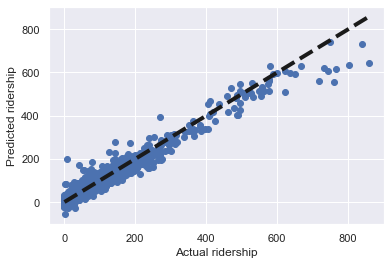

In [348]:
y = test_vald_labels
fig, ax = plt.subplots()
ax.scatter(y, pred_y)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual ridership')
ax.set_ylabel('Predicted ridership')
plt.show()

In [349]:
pd.set_option("display.max_rows", 100)
result = pd.DataFrame(test_vald_data)
result['actual_ridership'] = test_vald_labels.values
result['predicted_ridership'] = pred_y
result.tail(100)

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,actual_ridership,predicted_ridership
2712,-1.498644,-1.479080,-0.741860,-0.108471,-0.307744,0.707502,0.0,0.562447,0.750488,0.127862,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,3.0,7.752901
2713,0.662671,1.019258,0.519863,-0.958018,-0.594563,-0.927855,0.0,-1.280959,-1.640769,-0.044349,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,33.0,33.028424
2714,-2.337363,-2.624151,-2.093705,-0.763168,-0.953086,-0.694233,0.0,1.299810,1.547573,0.231188,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,176.0,182.900731
2715,-0.584655,-0.854495,0.159371,0.296817,-0.020925,0.629627,0.0,0.931128,1.149030,0.196746,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,30.0,-1.290427
2716,0.006749,0.394674,0.069248,-0.521554,0.409303,-0.460611,0.0,-0.174916,-0.046598,0.093420,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,363.0,376.732184
2717,0.619660,0.082381,1.150724,0.250053,-0.164334,0.785376,0.0,-0.174916,-0.046598,0.058978,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,133.0,109.547930
2718,-1.025520,-0.854495,-0.922106,0.343581,0.337599,-0.304862,0.0,1.299810,1.149030,0.196746,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,490.0,404.083976
2719,0.254064,1.747940,0.159371,-1.246396,0.839532,-0.772107,0.0,-1.280959,-1.242226,-0.009906,...,0.0,-0.059449,-0.005658,-0.019604,-1.109465,1.118340,0.02773,-0.02773,63.0,54.287133
2720,-0.649172,-1.062690,-0.110998,1.185333,0.624418,1.174746,0.0,0.931128,0.750488,0.196746,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,113.0,111.614644
2721,-1.176059,-1.687275,-0.471490,-0.046119,-0.307744,0.396005,0.0,0.931128,1.149030,0.196746,...,0.0,-0.059449,-0.005658,-0.019604,0.901336,-0.894182,0.02773,-0.02773,11.0,21.162009


In [351]:
# lgb.plot_importance(model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance',
#                         xlabel='Feature importance', ylabel='Features', importance_type='gain', max_num_features=15);

**To be changed only after robust CV indicating the bettter score of 0.5365**

**Predict labels for test data and submit result**

In [ ]:
#Do predicitons bassis on model defined and trained earlier
xgtest = xgb.DMatrix(test_X)
predict_y = xgb_clf.predict(xgtest)

out_df = pd.DataFrame(predict_y)
out_df['listing_id'] = test_df.listing_id.values
out_df.columns = ['high','medium','low', 'listing_id']
cols = ['listing_id', 'high','medium', 'low']
out_df = out_df[cols]
out_df.to_csv('Desktop/MachineLearning/datasets/rental-listing/rentalListingResult.csv', header=True, index=False)